In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM
from PFNExperiments.LinearRegression.Models.Transformer_CNF import TransformerCNFConditionalDecoder
from PFNExperiments.Training.FlowMatching.CFMLossOT2 import CFMLossOT2
from PFNExperiments.LatentFactorModels.Training.TrainerCurriculumCNF_LatentFactor import TrainerCurriculumCNF_LatentFactor
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF import ModelToPosteriorCNF
from PFNExperiments.LatentFactorModels.ComparisonModels.Hamiltionian_MC import Hamiltionian_MC
from PFNExperiments.Evaluation.Evaluate import Evaluate, results_dict_to_data_x_tuple, result_dict_to_latent_variable_convert_mu_sigma_to_beta, results_dict_to_data_x_tuple_transpose

In [3]:
from PFNExperiments.LatentFactorModels.GenerativeModels.Clustering.GMMs import make_gmm_program_spherical, make_gmm_program_spherical_batched
from PFNExperiments.LatentFactorModels.GenerativeModels.LatenFactorModel_abstract import return_only_x

from PFNExperiments.LatentFactorModels.ComparisonModels.MakeDefaultListComparison import make_default_list_comparison, make_reduced_list_comparison


In [4]:
N = 10
P = 4
K = 3
BATCH_SIZE = 1024
N_EPOCHS = 100
N_SAMPLES_PER_EPOCH = 500_000
N_BATCHES_PER_EPOCH = N_SAMPLES_PER_EPOCH//BATCH_SIZE

In [5]:
curriculum = Curriculum(max_iter=int(N_EPOCHS*N_BATCHES_PER_EPOCH*BATCH_SIZE*0.5))
curriculum.add_param_list([
    ("n", curriculum.constant_scheduler(N)),
    ("p", curriculum.constant_scheduler(P)),
    ("k", curriculum.constant_scheduler(K)),
    ("batch_size", curriculum.constant_scheduler(BATCH_SIZE)),
    ("a1", curriculum.constant_scheduler(5.0)),
    ("b1", curriculum.constant_scheduler(2.0)),
    ("dirichlet_beta", curriculum.constant_scheduler(1.0)),
    ("lambda1", curriculum.constant_scheduler(3.0))
])
#curriculum.plot_all_schedules()

In [6]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_gmm_program_spherical_batched,
    curriculum= curriculum,
)

pprogram_covariates_train is None, using pprogram_covariates instead
pprogram_covariates_val is None, using pprogram_covariates instead
pprogram_covariates_test is None, using pprogram_covariates instead


In [7]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
    )

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [8]:
sample_batch = next(iter(epoch_loader[0][0]))

####################################################################################################
Epoch 0


100%|██████████| 10/10 [00:00<00:00, 67.52it/s]


{'X': {'mean': tensor(0.5008), 'variance': tensor(0.0830), 'min': tensor(1.8537e-05), 'max': tensor(1.0000), 'mean_mean': tensor([0.5030, 0.4976, 0.5024, 0.5001]), 'variance_mean': tensor([0.0828, 0.0833, 0.0821, 0.0836]), 'min_mean': None, 'max_mean': None}, 'beta': {'mean': tensor(0.2572), 'variance': tensor(1.4938), 'min': tensor(-11.3255), 'max': tensor(14.4639), 'mean_mean': tensor(0.2572), 'variance_mean': tensor(1.5583), 'min_mean': None, 'max_mean': None}}
Statistics for phi:
Mean: tensor([0.3300, 0.3345, 0.3354])
Variance: tensor([0.0539, 0.0541, 0.0553])
Min: tensor([4.2601e-05, 2.8634e-04, 8.3049e-04])
Max: tensor([0.9911, 0.9985, 0.9842])
Mean of means: 0.3333333730697632
Mean of variances: 0.08160920441150665
Mean of minimums: None
Mean of maximums: None


Statistics for mu:
Mean: tensor([0.0071, 0.0405, 0.0105])
Variance: tensor([2.9187, 2.7885, 3.0365])
Min: tensor([-11.3255,  -9.6906, -10.7594])
Max: tensor([11.8261, 11.0056, 14.4639])
Mean of means: 0.01938385143876075

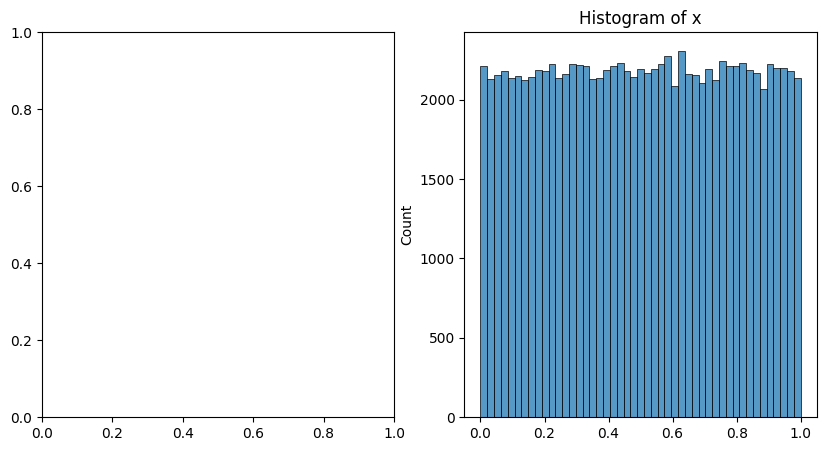

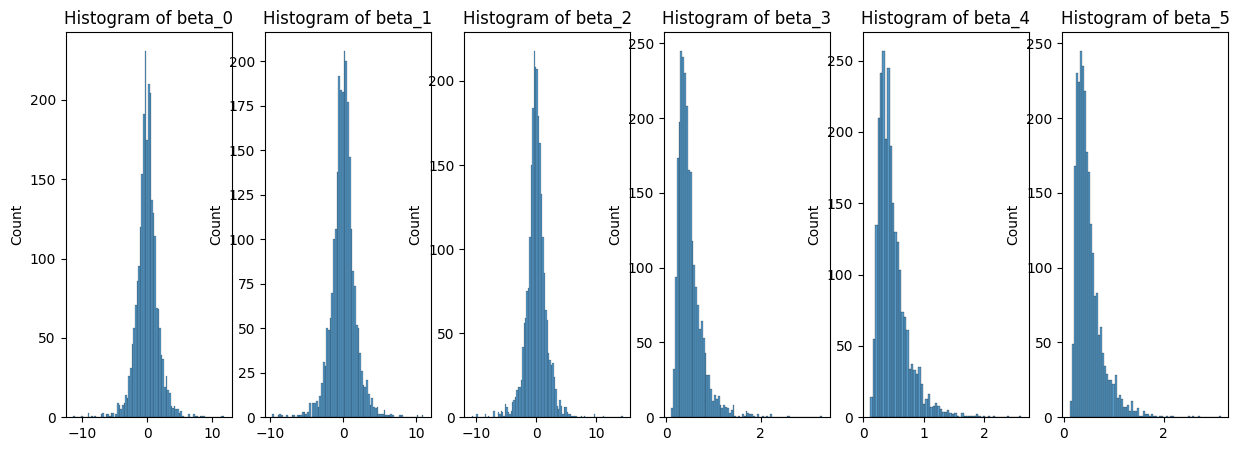

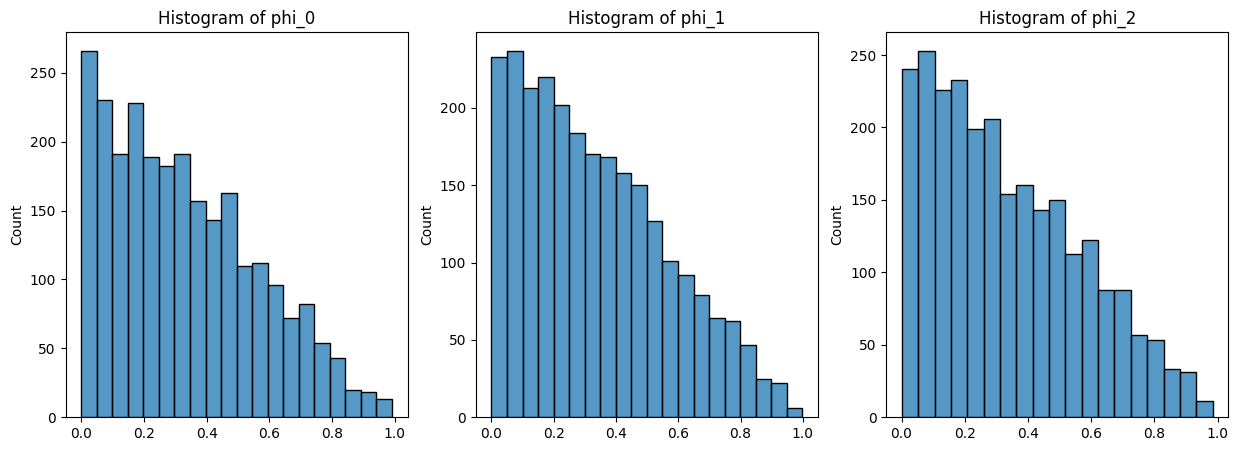

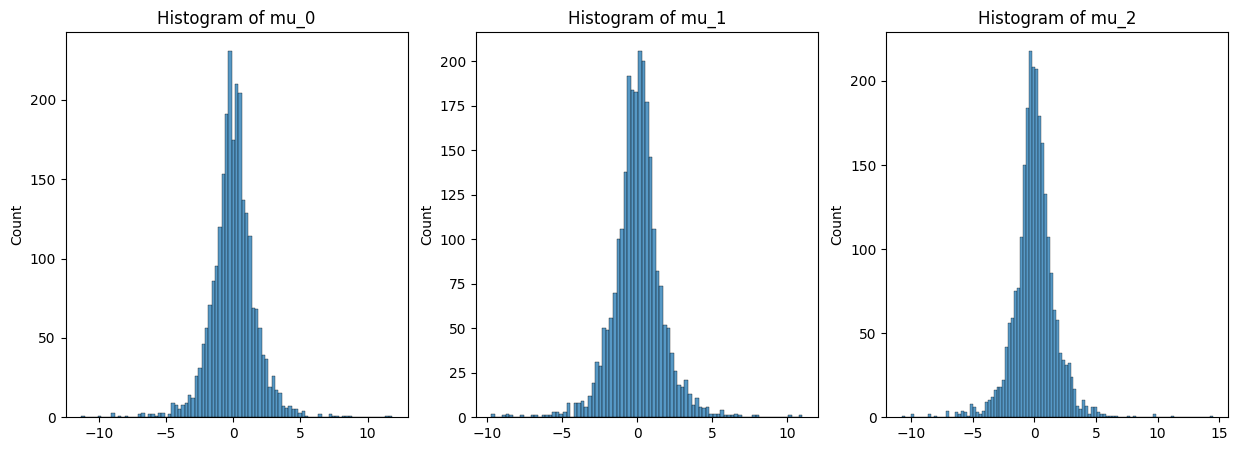

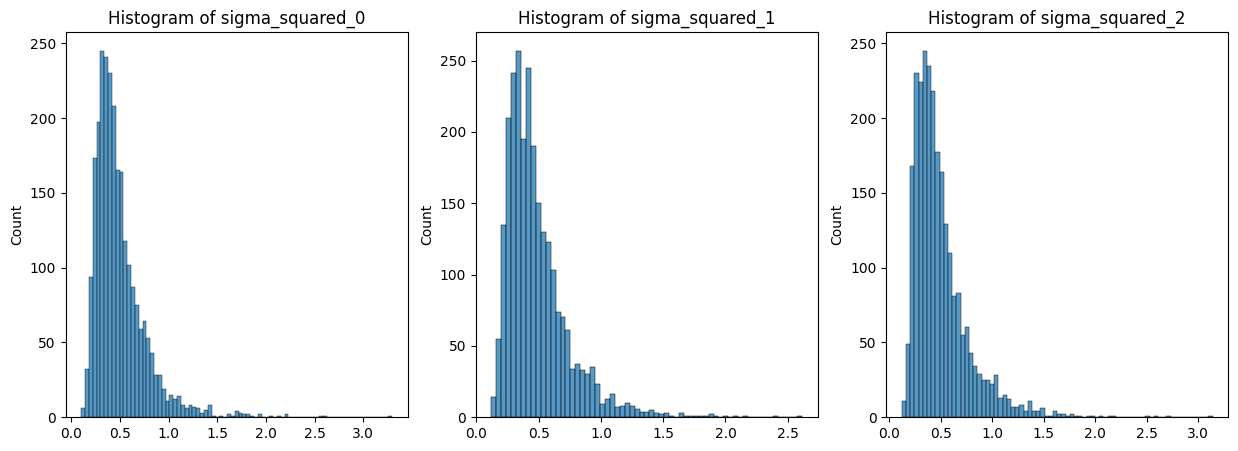

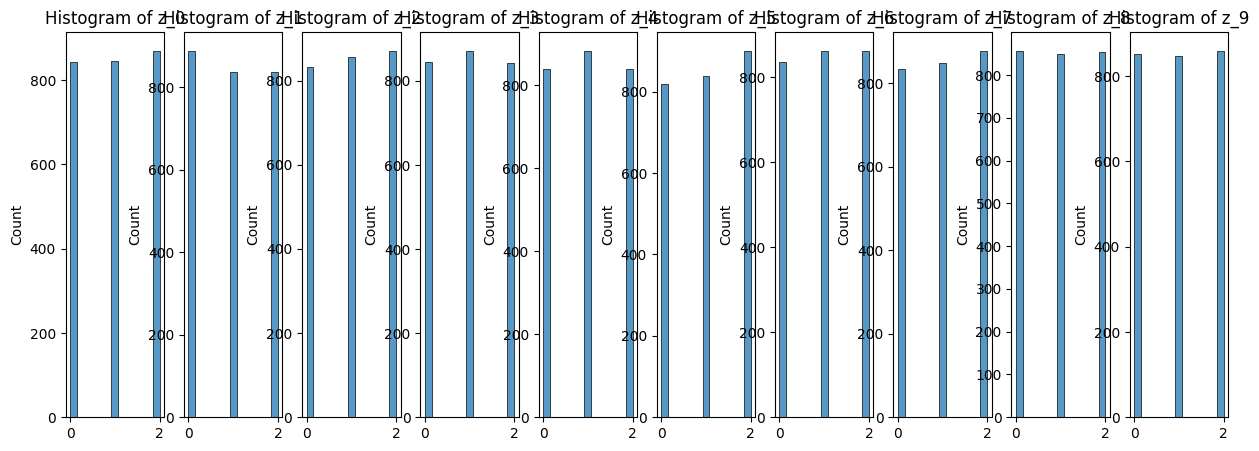

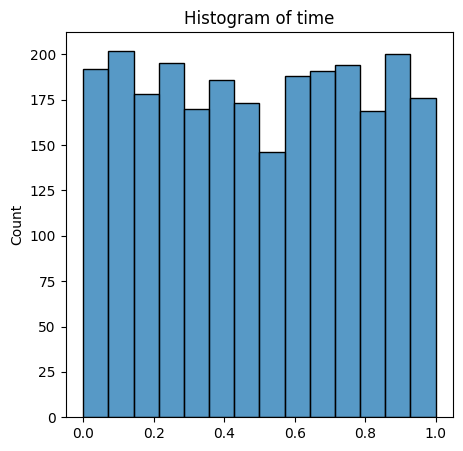

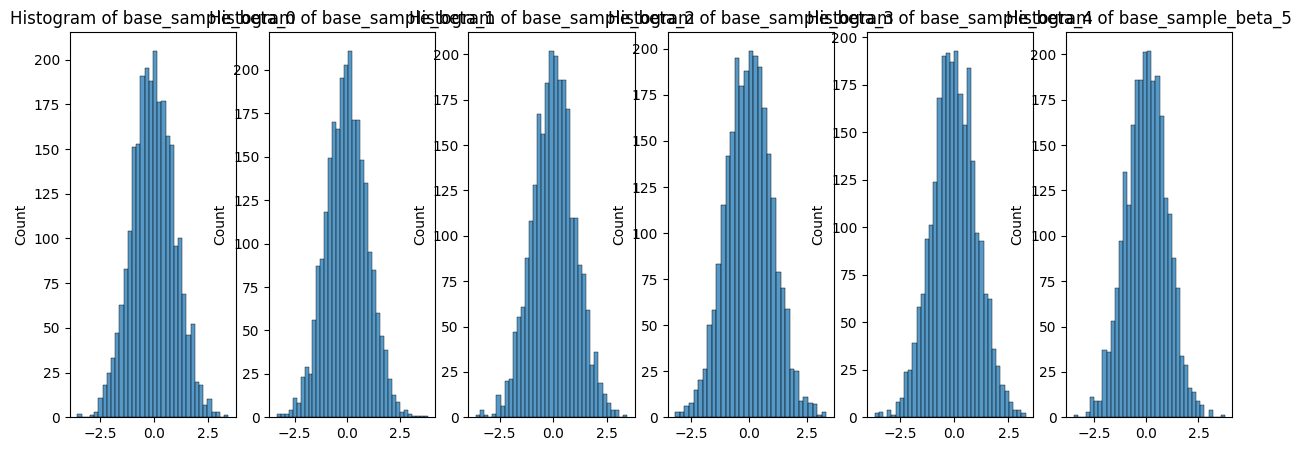

####################################################################################################
Epoch 99


100%|██████████| 10/10 [00:00<00:00, 83.84it/s]

{'X': {'mean': tensor(0.5003), 'variance': tensor(0.0833), 'min': tensor(5.3048e-06), 'max': tensor(1.0000), 'mean_mean': tensor([0.4995, 0.4990, 0.5011, 0.5014]), 'variance_mean': tensor([0.0831, 0.0834, 0.0840, 0.0826]), 'min_mean': None, 'max_mean': None}, 'beta': {'mean': tensor(0.2370), 'variance': tensor(1.5123), 'min': tensor(-12.8188), 'max': tensor(17.2663), 'mean_mean': tensor(0.2370), 'variance_mean': tensor(1.5909), 'min_mean': None, 'max_mean': None}}
Statistics for phi:
Mean: tensor([0.3270, 0.3349, 0.3381])
Variance: tensor([0.0544, 0.0548, 0.0557])
Min: tensor([1.0122e-03, 8.1279e-06, 1.2140e-06])
Max: tensor([0.9725, 0.9828, 0.9801])
Mean of means: 0.3333333730697632
Mean of variances: 0.08243346959352493
Mean of minimums: None
Mean of maximums: None


Statistics for mu:
Mean: tensor([-0.0315, -0.0535, -0.0030])
Variance: tensor([2.9661, 2.9314, 2.9321])
Min: tensor([-12.8188, -12.4967, -10.7512])
Max: tensor([17.2663,  9.2991,  9.5435])
Mean of means: -0.0293604433536

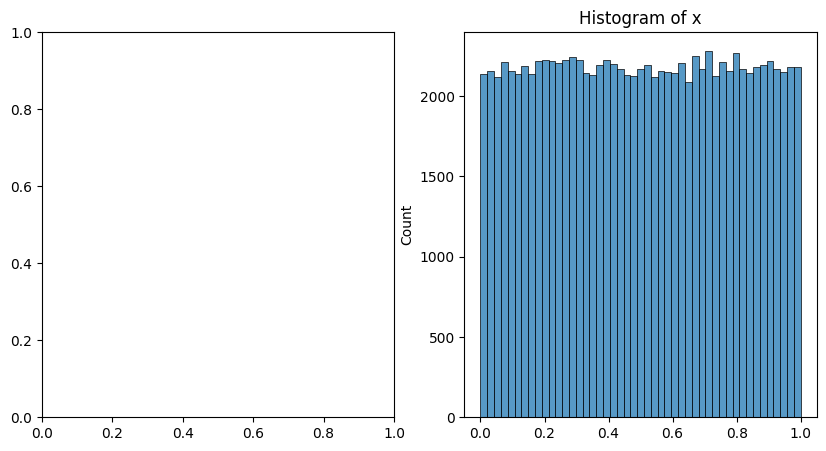

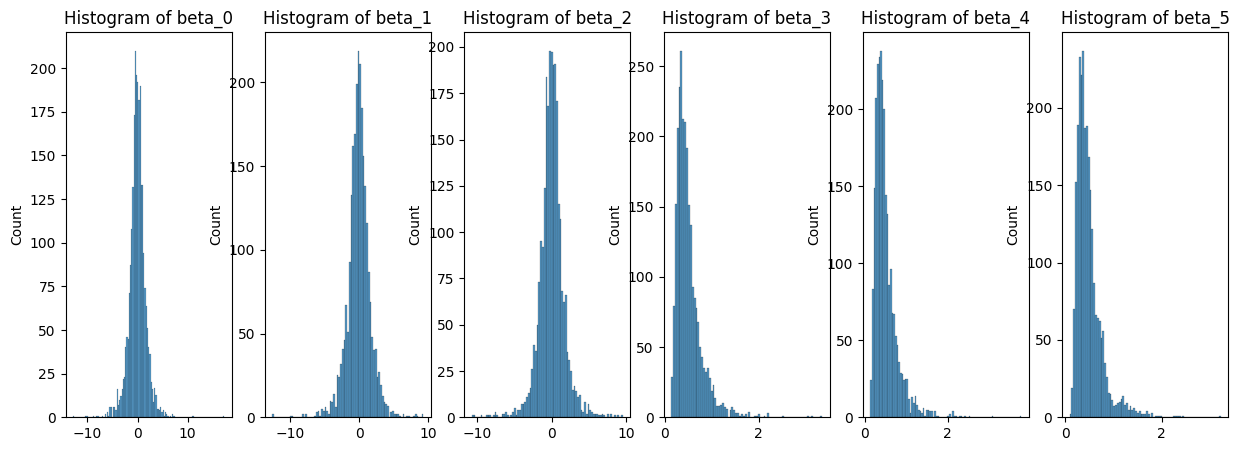

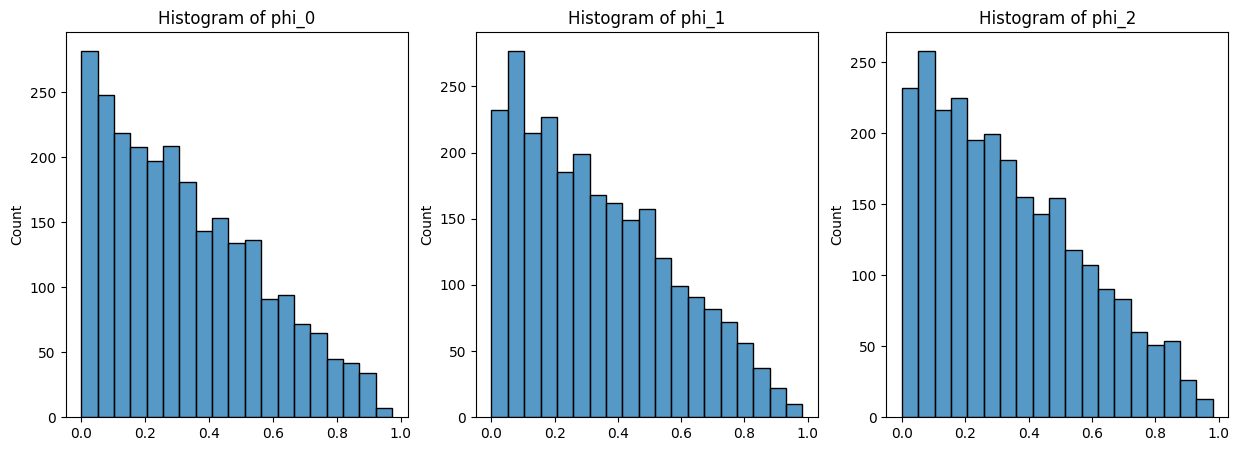

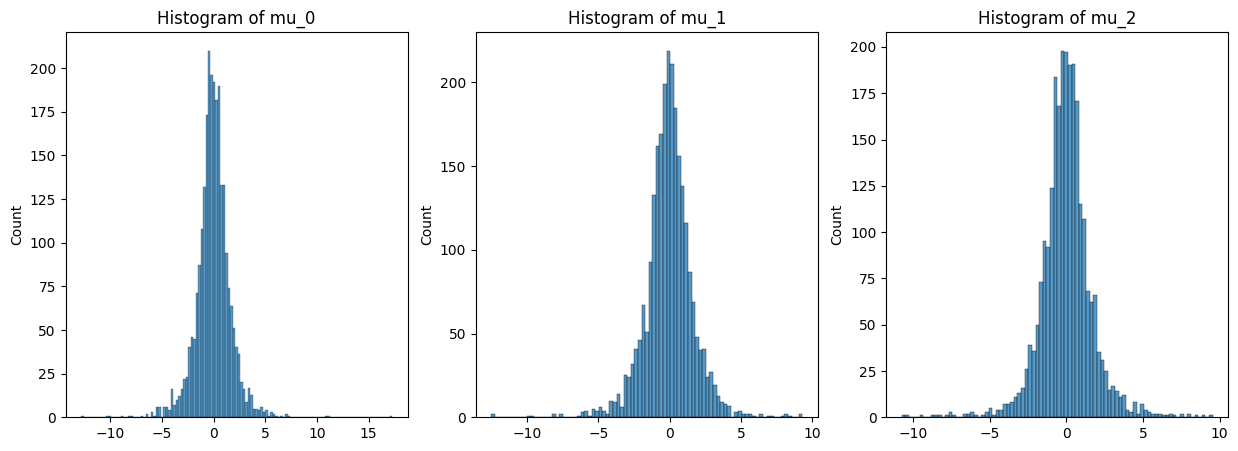

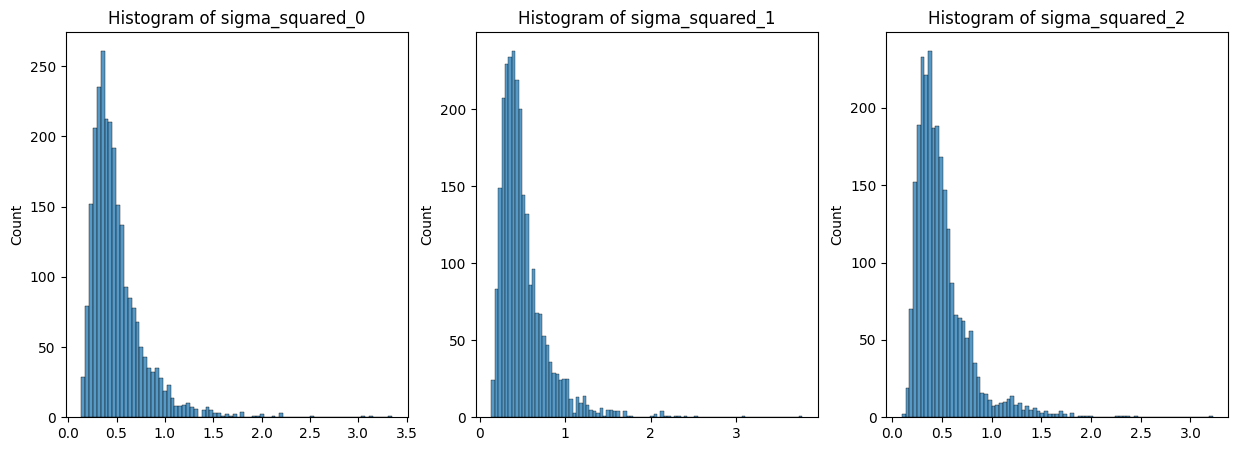

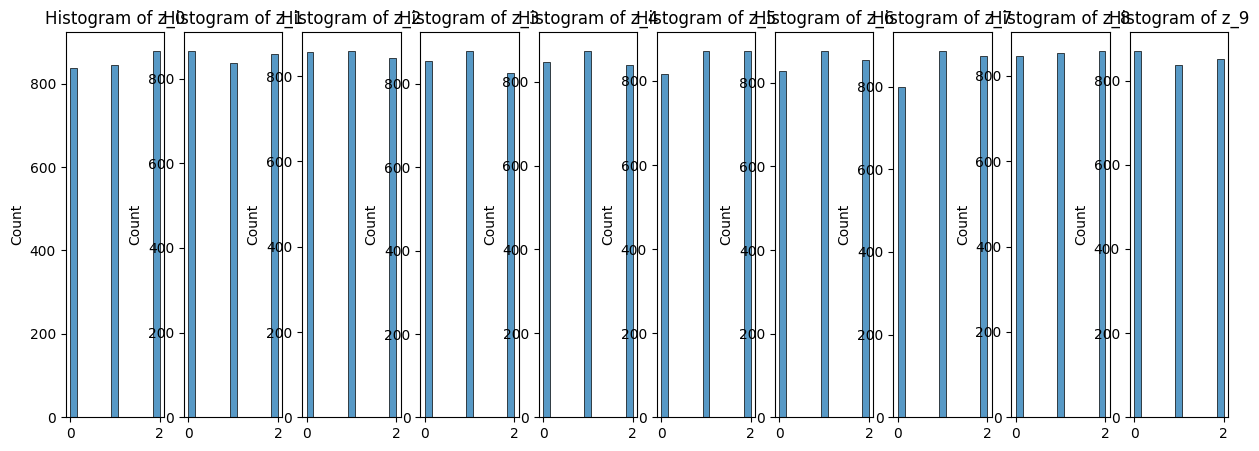

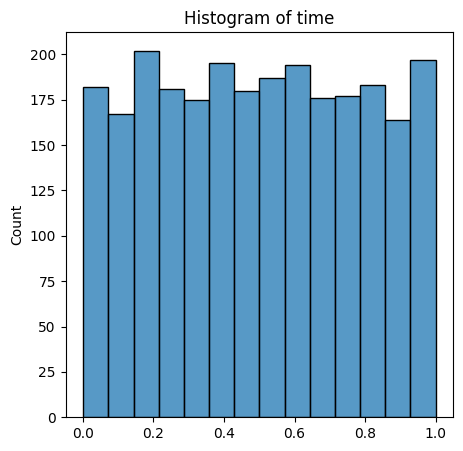

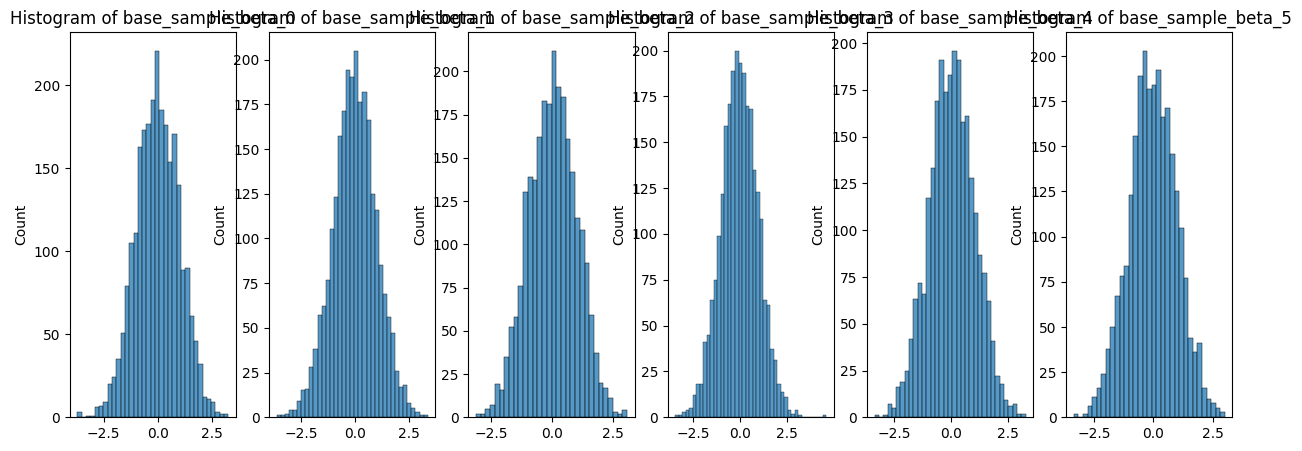

[{'X': {'mean': tensor(0.5008),
   'variance': tensor(0.0830),
   'min': tensor(1.8537e-05),
   'max': tensor(1.0000),
   'mean_mean': tensor([0.5030, 0.4976, 0.5024, 0.5001]),
   'variance_mean': tensor([0.0828, 0.0833, 0.0821, 0.0836]),
   'min_mean': None,
   'max_mean': None},
  'beta': {'mean': tensor(0.2572),
   'variance': tensor(1.4938),
   'min': tensor(-11.3255),
   'max': tensor(14.4639),
   'mean_mean': tensor(0.2572),
   'variance_mean': tensor(1.5583),
   'min_mean': None,
   'max_mean': None}},
 {'X': {'mean': tensor(0.5003),
   'variance': tensor(0.0833),
   'min': tensor(5.3048e-06),
   'max': tensor(1.0000),
   'mean_mean': tensor([0.4995, 0.4990, 0.5011, 0.5014]),
   'variance_mean': tensor([0.0831, 0.0834, 0.0840, 0.0826]),
   'min_mean': None,
   'max_mean': None},
  'beta': {'mean': tensor(0.2370),
   'variance': tensor(1.5123),
   'min': tensor(-12.8188),
   'max': tensor(17.2663),
   'mean_mean': tensor(0.2370),
   'variance_mean': tensor(1.5909),
   'min_mean':

In [9]:
data_generator.check_model(
    n_samples_per_epoch=N_SAMPLES_PER_EPOCH,
    epochs_to_check = [0, N_EPOCHS-1],
    p = P,
    n = N,
    used_batch_samples = 10
)

In [10]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
)

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [11]:
sample_batch = next(iter(epoch_loader[0][0]))
sample_batch.keys()

dict_keys(['phi', 'mu', 'sigma_squared', 'z', 'x', 'beta', 'time', 'base_sample_beta'])

In [12]:
sample_batch["x"].shape, sample_batch["beta"].shape

(torch.Size([1024, 10, 4]), torch.Size([1024, 6]))

In [13]:
2*K

6

In [14]:
"""
model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = 1,
    n_input_features_decoder = 2*P,
    d_model_encoder = 512,
    d_model_decoder = 512,
    n_heads_encoder = 8,
    n_heads_decoder = 8,
    d_ff_encoder = 1024,
    d_ff_decoder = 1024,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 512,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = 2*P,
    d_final_processing = 512,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)
"""

model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = P,
    n_input_features_decoder = 2*K,
    d_model_encoder = 16,
    d_model_decoder = 16,
    n_heads_encoder = 1,
    n_heads_decoder = 1,
    d_ff_encoder = 16,
    d_ff_decoder = 16,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 16,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = 2*K,
    d_final_processing = 16,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)

In [15]:
loss_fun = CFMLossOT2(
    sigma_min=1e-4
)

In [16]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = OneCycleLR(opt,
                       max_lr = 5e-4,
                       epochs = N_EPOCHS,
                       steps_per_epoch = N_SAMPLES_PER_EPOCH//BATCH_SIZE,
                       pct_start = 0.1,
                       div_factor=25.0,
                       final_div_factor=1e4)

#scheduler = ReduceLROnPlateau(opt)

additional_evals = {
}



In [17]:
trainer = TrainerCurriculumCNF_LatentFactor(
    model = model,
    optimizer=opt,
    scheduler = scheduler,
    loss_function=loss_fun,
    epoch_loader = epoch_loader,
    evaluation_functions= additional_evals,
    n_epochs = N_EPOCHS,
    early_stopping_patience = 200,
    schedule_step_on = "batch",
    save_path = None,
    coupling = None,
    use_same_timestep_per_batch = False,
    use_train_mode_during_validation = False,
    max_gradient_norm = 1.0

)

In [18]:
trainer.validate()

100%|██████████| 49/49 [00:12<00:00,  3.84it/s]


{'loss_mean': 2.6691641807556152,
 'loss_median': 2.669611692428589,
 'loss_std': 0.08671390265226364}

In [19]:
r = trainer.train()

Curriculum parameters: {'n': 10, 'p': 4, 'k': 3, 'batch_size': 1024, 'a1': 5.0, 'b1': 2.0, 'dirichlet_beta': 1.0, 'lambda1': 3.0} at iteration 0


  1%|          | 3/244 [00:02<02:48,  1.43it/s]


KeyboardInterrupt: 

In [44]:
full_model = ModelToPosteriorCNF(
    model = model.eval(),
    sample_name = "beta",
    sample_shape = (2*K,),
    n_samples=1000,
    batch_size = BATCH_SIZE,
    solve_adjoint = True,
    atol = 10,
    rtol = 10,
    #device = torch.device("cpu")
)

benchmark_params_ppgrogram = data_generator.curriculum.get_params(-1)
del benchmark_params_ppgrogram["batch_size"]
print(f"params for pprogram: {benchmark_params_ppgrogram}")

pprogram1 = make_gmm_program_spherical(**benchmark_params_ppgrogram)

pprogram1_x = return_only_x(pprogram1)



params for pprogram: {'n': 10, 'p': 4, 'k': 3, 'a1': 5.0, 'b1': 2.0, 'dirichlet_beta': 1.0, 'lambda1': 3.0}


In [45]:
test_batch = next(iter(epoch_loader[0][1]))
x_test = test_batch["x"]

In [46]:
x_test.shape

torch.Size([1024, 10, 4])

In [47]:
full_model.sample_posterior(x_test[0])

0it [00:00, ?it/s]


{'beta': tensor([[ 0.1680,  0.2986, -1.4564, -1.4889, -0.3925,  0.5414],
         [-0.4318,  0.2120, -0.6964, -0.1643,  0.9223,  1.7027],
         [ 1.3581, -1.9876,  0.6850,  1.0328,  2.0711,  0.5225],
         ...,
         [ 0.0880, -0.3801,  0.2197,  1.1148,  0.0785, -0.7510],
         [-0.6479,  1.0986, -0.6600, -1.1443,  0.9861, -0.6584],
         [ 1.1059, -0.9552, -1.7304,  0.8679,  0.1004, -0.0031]],
        grad_fn=<CatBackward0>),
 'X': tensor([[0.6695, 0.6018, 0.8473, 0.2769],
         [0.2055, 0.0989, 0.5372, 0.6412],
         [0.7789, 0.4406, 0.3846, 0.9273],
         [0.1689, 0.7459, 0.5307, 0.6821],
         [0.4125, 0.6957, 0.7045, 0.9983],
         [0.8310, 0.3047, 0.0351, 0.8362],
         [0.9496, 0.2593, 0.2858, 0.4883],
         [0.8526, 0.1664, 0.4532, 0.5685],
         [0.4196, 0.5010, 0.9491, 0.3016],
         [0.6883, 0.5782, 0.2542, 0.3085]]),
 'y': None}

In [48]:
hmc = Hamiltionian_MC(
    pprogram=pprogram1_x,
    n_samples=500,
    n_warmup=500
)

models = make_default_list_comparison(pprogram= pprogram1_x, n_samples= 1000)

In [59]:
evaluation = Evaluate(
    posterior_model = full_model,
    evaluation_loader = trainer.testset,
    comparison_models= models[1:],
    n_evaluation_cases=2,
    save_path= None,
    overwrite_results = True,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_mu_sigma_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple_transpose
)

In [60]:
evaluation.run_evaluation()

Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]

Key: phi, value shape: torch.Size([1, 3])
Key: mu, value shape: torch.Size([1, 3])
Key: sigma_squared, value shape: torch.Size([1, 3])
Key: z, value shape: torch.Size([1, 10])
Key: x, value shape: torch.Size([1, 10, 4])
Key: beta, value shape: torch.Size([1, 6])
Key: time, value shape: torch.Size([1])
Key: base_sample_beta, value shape: torch.Size([1, 6])


0it [00:00, ?it/s]
Sampling posterior:  50%|█████     | 1/2 [00:01<00:01,  1.07s/it]

Key: phi, value shape: torch.Size([1, 3])
Key: mu, value shape: torch.Size([1, 3])
Key: sigma_squared, value shape: torch.Size([1, 3])
Key: z, value shape: torch.Size([1, 10])
Key: x, value shape: torch.Size([1, 10, 4])
Key: beta, value shape: torch.Size([1, 6])
Key: time, value shape: torch.Size([1])
Key: base_sample_beta, value shape: torch.Size([1, 6])


0it [00:00, ?it/s]
Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]


Key: phi, value shape: torch.Size([1, 3])
Key: mu, value shape: torch.Size([1, 3])
Key: sigma_squared, value shape: torch.Size([1, 3])
Key: z, value shape: torch.Size([1, 10])
Key: x, value shape: torch.Size([1, 10, 4])
Key: beta, value shape: torch.Size([1, 6])
Key: time, value shape: torch.Size([1])
Key: base_sample_beta, value shape: torch.Size([1, 6])
Data: (tensor([[0.6473, 0.5064, 0.0509, 0.5328],
        [0.7393, 0.8811, 0.7003, 0.7424],
        [0.7973, 0.8166, 0.1671, 0.4764],
        [0.3521, 0.5676, 0.8810, 0.0675],
        [0.4238, 0.6817, 0.6422, 0.4201],
        [0.5314, 0.8893, 0.1028, 0.6488],
        [0.5041, 0.0361, 0.4706, 0.2405],
        [0.4083, 0.8570, 0.6528, 0.8514],
        [0.0456, 0.9775, 0.4848, 0.7926],
        [0.1252, 0.2538, 0.8538, 0.0353]]), None)
Data shape: torch.Size([10, 4])


ValueError: Error while computing log_prob at site 'x':
Value is not broadcastable with batch_shape+event_shape: torch.Size([10, 4]) vs torch.Size([3, 4, 10]).
     Trace Shapes:            
      Param Sites:            
     Sample Sites:            
          phi dist         | 3
             value         | 3
          log_prob         |  
sigma_squared dist       3 |  
             value       3 |  
          log_prob       3 |  
           mu dist       3 |  
             value       3 |  
          log_prob       3 |  
            z dist      10 |  
             value 3  1  1 |  
          log_prob 3  1 10 |  
            x dist 3  4 10 |  
             value   10  4 |  

In [ ]:
from PFNExperiments.Evaluation.RealWorldEvaluation.PreprocessDataset import Preprocessor, PreprocessorClassification

In [ ]:
from PFNExperiments.Evaluation.RealWorldEvaluation.Preprocess_univariate_GMM import Preprocessor_GMM_univariate
from PFNExperiments.Evaluation.RealWorldEvaluation.GetDataOpenML import GetDataOpenML
getdata = GetDataOpenML(
    preprocessor = Preprocessor_GMM_univariate(
        N_datapoints = N,
        x_mean = 0.0,
        x_var = 1.0,
    ),
    save_path = "C:/Users/arik_/Documents/Dokumente/Job_Clausthal/PFNs/Repository/PFNExperiments/Evaluation/RealWorldEvaluation/DatasetsOpenML/Tabular_benchmark_numerical_regression.pkl",
    benchmark_id = 336
)
datasets = getdata.get_data()

In [ ]:
datasets[0]["x"].shape

torch.Size([10, 1])

In [ ]:
comparison_models = make_default_list_comparison(pprogram= pprogram1_x, n_samples= 1000)

In [ ]:
from PFNExperiments.Evaluation.RealWorldEvaluation.EvaluateRealWorld import EvaluateRealWorld


eval = EvaluateRealWorld(
    
    posterior_model = full_model,
    evaluation_datasets = datasets,
    comparison_models = comparison_models[1:3],
    n_evaluation_cases = 2,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_mu_sigma_to_beta
)

In [ ]:
eval.run_evaluation()


0it [00:00, ?it/s]

0it [00:00, ?it/s]
Sampling posterior: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


....................


....................


Sampling posterior: 100%|██████████| 2/2 [01:03<00:00, 31.59s/it]


....................


....................


Sampling posterior: 100%|██████████| 2/2 [01:05<00:00, 32.98s/it]


Comparison to ground truth:

Summarized results:

Comparison among models:

Summarized results:


,Model 1,Model 2,Mean_Wasserstein_distance with metric euclidean,Mean_MMD,Mean_cst_roc_auc,Std_Wasserstein_distance with metric euclidean,Std_MMD,Std_cst_roc_auc
0,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,3.315322,2.176648,0.9985,0.356501,0.213406,0.000707
1,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,2.984874,1.713836,0.9980,0.422907,0.027648,0.002121
2,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,3.369114,4.218278,1.0000,1.181957,0.256180,0.000000


P-values:


,Pair 1: Model A,Pair 1: Model B,Pair 2: Model A,Pair 2: Model B,Wasserstein_distance with metric euclidean_p-value,MMD_p-value,cst_roc_auc_p-value
0,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,0.666667,0.333333,1.000000
1,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,1.000000,0.245278,0.220671
2,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,1.000000,0.245278,0.220671


{'summarized_results': {'model_comparison_among_each_other':                                              Model 1  \
  0  <PFNExperiments.LinearRegression.Models.ModelT...   
  1  <PFNExperiments.LinearRegression.Models.ModelT...   
  2  Variational Inference with guide: _bound_parti...   
  
                                               Model 2  \
  0  Variational Inference with guide: _bound_parti...   
  1  Variational Inference with guide: _bound_parti...   
  2  Variational Inference with guide: _bound_parti...   
  
     Mean_Wasserstein_distance with metric euclidean  Mean_MMD  \
  0                                         3.315322  2.176648   
  1                                         2.984874  1.713836   
  2                                         3.369114  4.218278   
  
     Mean_cst_roc_auc  Std_Wasserstein_distance with metric euclidean   Std_MMD  \
  0            0.9985                                        0.356501  0.213406   
  1            0.9980                 